In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Image classification

In this tutorial we will study in more detail how to build a simple network using pytorch : [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).
The code in this tutorial is based on a [example](https://github.com/pytorch/examples/blob/master/mnist/main.py) in pytorch 

This network is a convolutional network that has the goal of doing image classification.

This [tuto](https://www.superdatascience.com/blogs/the-ultimate-guide-to-convolutional-neural-networks-cnn) will allow you to go into more detail in the explanation of this network

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

torch.manual_seed(1)
use_cuda = torch.cuda.is_available()

## step 1 : definition of the train image and evaluation

It is important to start by defining the images we will be working on.
Here, we will work on the MNIST dataset, containing images of handwritten numbers.

The purpose of the network will be to determine what number is written on the image. To do this, he will have to learn to correctly classify the images with a training dataset. He will then be able to test his learning with a second dataset.

These two dataset must be different

In [3]:
# size of the training batch
train_batch_size = 64
# size of the test batch
test_batch_size = 1000

# data transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


# dataset import
dataset = datasets.MNIST('images', download=True, transform=transform)

# number of images for training (80% of total data)
nb_train = int(0.8*len(dataset))
# number of images for the test (the rest of the data)
nb_test  = len(dataset)-nb_train

# separation of data into two datasets
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [nb_train, nb_test])


# Data loading
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size,  shuffle=True, **kwargs)

In [4]:
print("The training set contains {} images, in {} batches of {} images".format(len(train_loader.dataset),
                                                                                      len(train_loader),
                                                                                      train_batch_size))
print("The test set contains {} images, in {} batches of {} images".format(len(test_loader.dataset),
                                                                               len(test_loader),
                                                                               test_batch_size))

The training set contains 48000 images, in 750 batches of 64 images
The test set contains 12000 images, in 12 batches of 1000 images


## step 2 : Network

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # convolution 1
        self.conv2 = nn.Conv2d(20, 50, 5, 1) # convolution 2
        self.fc1 = nn.Linear(4*4*50, 500) # fully connected 1
        self.fc2 = nn.Linear(500, 10) # fully connected 2

    def forward(self, x):
        # Extraction of characteristics 1
        x = F.relu(self.conv1(x)) # activation
        x = F.max_pool2d(x, 2, 2) # pooling
        
        # Extraction of characteristics 2
        x = F.relu(self.conv2(x)) # activation
        x = F.max_pool2d(x, 2, 2) # pooling
        x = x.view(-1, 4*4*50) # flattening
        
        # Classification
        x = F.relu(self.fc1(x)) # activation
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

the LeNet network consists of two main steps:
- the extraction of the image characteristics
- the classification of this image according to its characteristics

<img src="https://miro.medium.com/max/3712/1*7K4ZTTfZb-hbjoADbisHAg.png" width="600"/>

#### extraction of the image characteristics

to extract its characteristics the image will be modified in a series of steps: 

- a **convolution** (see [Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d), [image parameters](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md))
     - a convolution is a function derived from two functions given by integration that expresses how the shape of one is modified by the other
     - the image is convoluted by characteristic detectors (called kernel)
     - Attention the entry each convolution layer must be the same size as the exit of the previous convolution layer
<img src="https://stanford.edu/~shervine/images/convolution-layer-a.png" width="600"/>
<img src="https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/35_blog_image_11.png" width="600"/>

- an **activation function** : Linear Rectification Unit function (see [ReLu()](https://pytorch.org/docs/stable/nn.html#relu))
    - to keep only the positive values in the characteristic cards generated by the convolution
    - ReLU(x)=max(0,x) <img src="https://pytorch.org/docs/stable/_images/ReLU.png" width="400"/>



- a **Pooling** : Max Pooling (see [MaxPool2d](https://pytorch.org/docs/stable/nn.html#maxpool2d))
    - to keep only the maximum values in an area
    - reduces the characteristic map
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png" width="300"/>

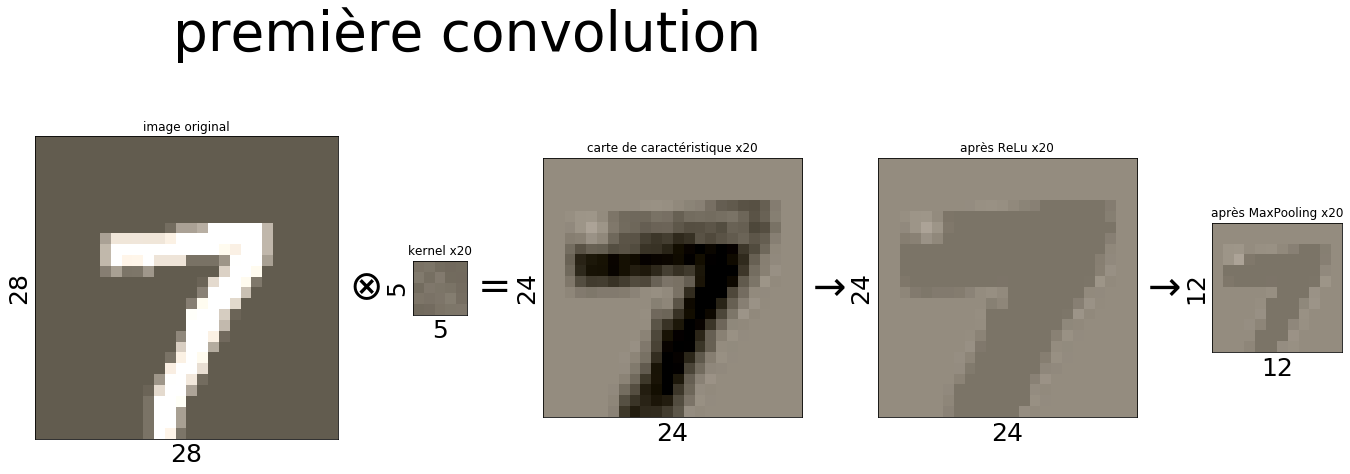

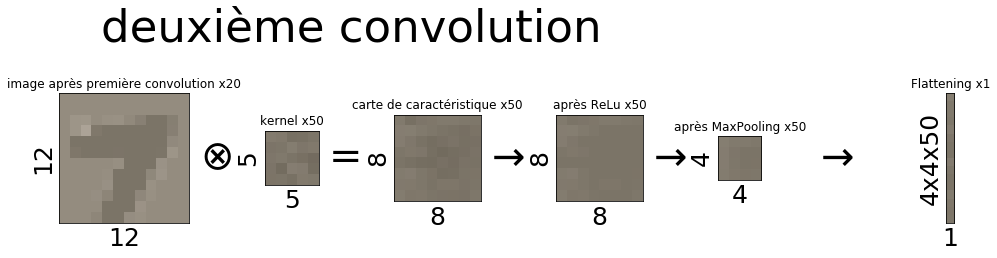

In [6]:
inputs = list(dict(iter(train_loader)).keys())

from convolution import Plot_img_conv
Plot_img_conv(inputs[13][13]);

### Classification

- **fully connected** - Linear (see [Linear](https://pytorch.org/docs/stable/nn.html#linear))
    - Applies a linear transformation to input data
<img src="https://jdlm.info/assets/driverless/27-fully-connected.png" width="900"/>     

- log_softmax (see [log_softmax](https://pytorch.org/docs/stable/nn.functional.html#log-softmax))

## step 3 : Network Training

- definition **Function loss** + find the right one!  [wiki](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif)

    The loss layer specifies how the network drive penalizes the difference between the expected and actual signal. It is normally the last layer in the network.

    Various loss functions adapted to different tasks can be used there [loss-functions](https://pytorch.org/docs/stable/nn.functional.html#loss-functions) :
    - The "Softmax" loss is used to predict only one of K mutually exclusive classes.
    - The sigmoid cross entropy loss is used to predict K values of independent probability in [0.1].
    - The Euclidean loss is used to regress to real values in [-inf ,inf].

The negative log likelihood loss -> allows to maximize the error when the right label has a low probability and to decrease it when the right label has a high probability!

- Backpropagation
    - the computation error spreads to the first layer of the network
<img src="https://d3i71xaburhd42.cloudfront.net/db39fd79bb591b04d33207992f6ccde03cabd861/7-Figure1-1.png" width="400"/>

    - To perform backpropagation in pytorch, the following steps are necessary for each iteration of the loop:

        1. **optimize.zero_grad()** : resets the gradients of each parameter to zero.
        2. **loss.backward()** : calculates the gradiants for each variable by backpropagation according to the loss, and stores them in the Variable object
        3. **optimize.step()** : Modifies each model parameter (network weight) to minimize loss.

In [7]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train() # put in training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad() # important ! resets the gradients to 0
        output = model(data) # calculates the prediction
        loss = F.nll_loss(output, target) # calculates the error: The negative log likelihood loss.
        loss.backward() # drifts the graph
        optimizer.step() # performs an optimization step
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [8]:
# we tell the model if we want to work on a GPU or a CPU
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)

# the optimizer allows to calculate the network weights
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train(model, device, train_loader, optimizer, 0, 749)

Train Epoch: 0 [0/48000 (0%)]	Loss: 2.304014
Train Epoch: 0 [47936/48000 (100%)]	Loss: 0.095705


## step 3 : Network Test

In [9]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct/len(test_loader.dataset)))
    return(100. * correct/len(test_loader.dataset))

we're going to test the model for 15 trials.

In [10]:
dict_test = dict(iter(test_loader))
inps = list(dict_test.keys())
inp = inps[0][:15]
targ = dict_test[inps[0]][:15]

i = inp.view(inp.shape[0], 1, inp.shape[2], inp.shape[3])

out = model(i.to(device))
pred = out.argmax(dim=1, keepdim=True)
print('target :', targ,
      '\nprediction :', pred.to('cpu').view(-1),
      '\nnumber of good predictions :', pred.eq(targ.to(device).view_as(pred)).sum().item())

target : tensor([2, 8, 1, 2, 0, 1, 6, 3, 7, 9, 4, 4, 9, 0, 3]) 
prediction : tensor([2, 8, 1, 2, 0, 1, 6, 3, 7, 9, 4, 4, 9, 0, 3]) 
number of good predictions : 15


## step 4 : evolution of accuracy at the heart of epochs

we train the model on several epochs by testing it for each epoch in order to see its evolution

In [11]:
# we tell the model if we want to work on a GPU or a CPU
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
# the optimizer allows to calculate the network weights
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [12]:
#########################################################
# to reset the weights in the model to zero!
#########################################################
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

model.apply(weight_reset)
#########################################################

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [13]:
epochs = 15
log_interval = 749

list_accuracy = []
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    accuracy = test(model, device, test_loader)
    list_accuracy.append(accuracy)

# Save model
torch.save(model.state_dict(),"mnist_cnn.pt")

Train Epoch: 1 [0/48000 (0%)]	Loss: 2.311310
Train Epoch: 1 [47936/48000 (100%)]	Loss: 0.160318

Test set: Average loss: 0.1306, Accuracy: 11512/12000 (96%)

Train Epoch: 2 [0/48000 (0%)]	Loss: 0.281382
Train Epoch: 2 [47936/48000 (100%)]	Loss: 0.063285

Test set: Average loss: 0.0858, Accuracy: 11676/12000 (97%)

Train Epoch: 3 [0/48000 (0%)]	Loss: 0.076020
Train Epoch: 3 [47936/48000 (100%)]	Loss: 0.067499

Test set: Average loss: 0.0790, Accuracy: 11696/12000 (97%)

Train Epoch: 4 [0/48000 (0%)]	Loss: 0.132816
Train Epoch: 4 [47936/48000 (100%)]	Loss: 0.046189

Test set: Average loss: 0.0558, Accuracy: 11794/12000 (98%)

Train Epoch: 5 [0/48000 (0%)]	Loss: 0.043741
Train Epoch: 5 [47936/48000 (100%)]	Loss: 0.012019

Test set: Average loss: 0.0474, Accuracy: 11829/12000 (99%)

Train Epoch: 6 [0/48000 (0%)]	Loss: 0.038197
Train Epoch: 6 [47936/48000 (100%)]	Loss: 0.023315

Test set: Average loss: 0.0407, Accuracy: 11851/12000 (99%)

Train Epoch: 7 [0/48000 (0%)]	Loss: 0.011368
Train E

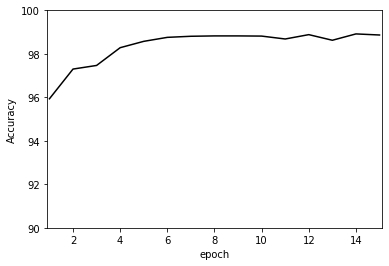

In [14]:
plt.plot(np.arange(1,len(list_accuracy)+1), list_accuracy, 'k')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.axis([0.9,len(list_accuracy)+0.1,90,100]);

## Visualization of the Kernels of the two convolutions of the network

The kernels used by the model are stored in:
- `model.conv1.weight` for the first convolution
- `model.conv2.weight` for the second convolution

In [15]:
from convolution import transform_img

**All kernels of convolution 1 :**

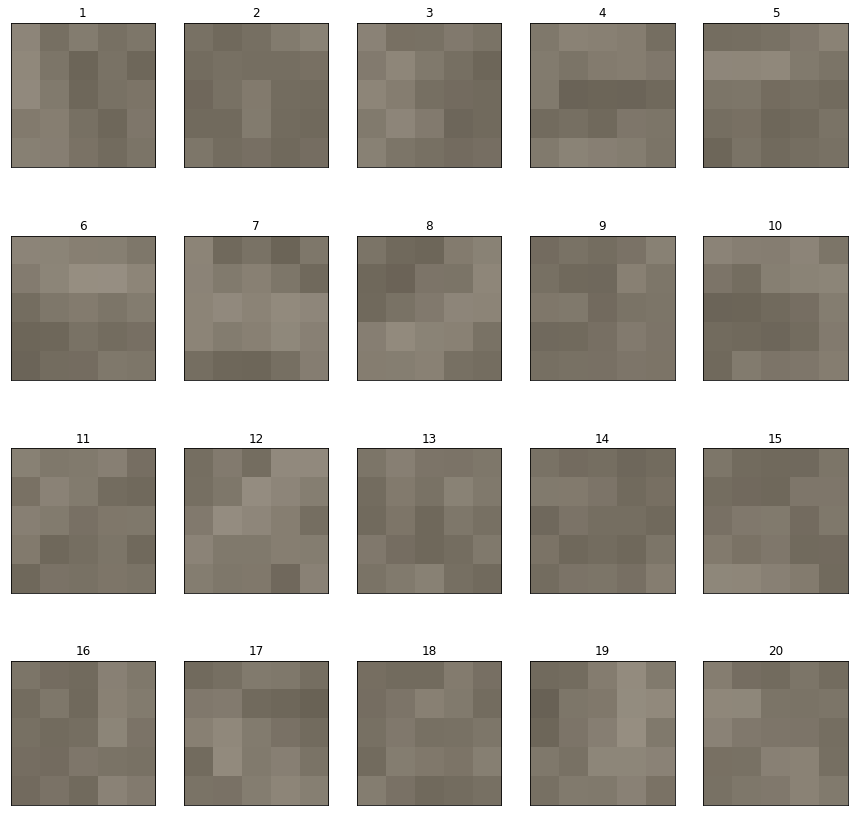

In [16]:
fig, ax = plt.subplots(4,5, figsize=(15,15))
for num_w in range(model.conv1.weight.shape[0]) :
    w = model.conv1.weight[num_w].to('cpu')
    
    a, b = num_w//5, num_w%5
    ax[a][b].imshow(transform_img(w))
    ax[a][b].set_title(num_w+1)
    ax[a][b].set_xticks([]) ; ax[a][b].set_yticks([])
plt.show()

**All kernels of convolution 2 for the characteristic cards of the first kernel of convolution 1 :**

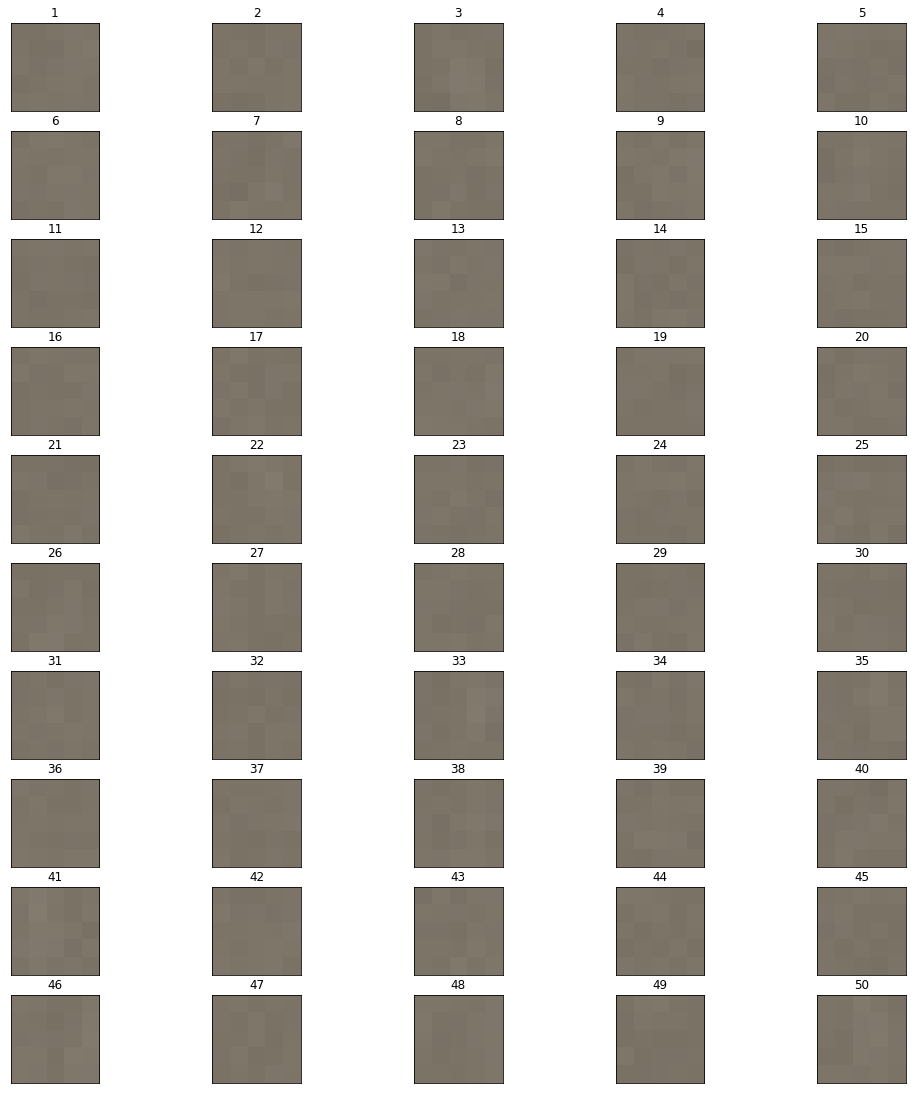

In [17]:
fig, ax = plt.subplots(10,5, figsize=(15,15))
for num_w in range(model.conv2.weight.shape[0]) :
    w = model.conv2.weight[num_w][0].view(1,5,5).to('cpu')
    
    a, b = num_w//5, num_w%5
    ax[a][b].imshow(transform_img(w))
    ax[a][b].set_title(num_w+1)
    ax[a][b].set_xticks([]) ; ax[a][b].set_yticks([])
plt.tight_layout(pad=0)
plt.show()